In [100]:
import numpy as np
import pandas as pd  
import random as rnd
import math
from tqdm import tqdm_notebook
from sklearn.metrics import make_scorer, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, NearestCentroid
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from IPython.display import display, HTML
from utils import mae_score, NPR
from joblib import Parallel, delayed

%matplotlib inline
import matplotlib.pyplot as plt

In [83]:
def mae_score(y_pred, y):
#     if norm:
#         y_ = y / np.linalg.norm(y, axis=1, ord=1)[:,None]
    return (np.linalg.norm(y_pred - y, axis=1, ord=1)/ (np.linalg.norm(y, axis=1, ord=1) + 1e-10)).mean()

In [84]:
scorer_mae = make_scorer(mae_score, greater_is_better=False)
# knn = KNeighborsRegressor(n_neighbors=4, leaf_size=30, p=2, weights='distance')
knn=LGBMRegressor()
mo_knn = MultiOutputRegressor(knn)

In [85]:
dataset_name = 'ptb'
tax_name = 'f'
mf_method_name = 'lle'

errs = []
dataframe = pd.read_csv(f'{dataset_name}/pivot_{tax_name}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
dataframe = dataframe.drop('Unnamed: 0', axis = 1).values
data = np.genfromtxt(f"./separate_datasets_proj/{dataset_name}_proj_{tax_name.lower()}.csv", delimiter=';')
data_trans = np.genfromtxt(f"./separate_datasets_transformed/{dataset_name}_proj_{tax_name.lower()}_{mf_method_name}.csv", delimiter=';')
# data_trans = np.load(f"./separate_datasets_transformed/{dataset_name}_proj_{tax_name.lower()}_{mf_method_name}.npy") # , delimiter=';'

# transformer = Isomap(n_components=n)
# dataset_transformed = transformer.fit_transform(data_AGP_g)
# errs_AGP_g.append(-cross_val_score(mo_knn, dataset_transformed, data_AGP_g, scoring=scorer_mae, cv=5, n_jobs=-1).mean())

In [86]:
param_grid = {'estimator__max_depth':[5,6,10,15], 
              'estimator__reg_alpha':[1e-1,1e-2,1e-3],
              'estimator__reg_lambda':[1e-1,1e-2,1e-3],
             'estimator__n_estimators':[2000]}
gs = GridSearchCV(mo_knn, param_grid, scoring=scorer_mae, cv=5, n_jobs=-1)
gs.fit(data_trans, dataframe)

GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=LGBMRegressor()),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [5, 6, 10, 15],
                         'estimator__n_estimators': [2000],
                         'estimator__reg_alpha': [0.1, 0.01, 0.001],
                         'estimator__reg_lambda': [0.1, 0.01, 0.001]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [87]:
gs.best_score_

-0.5212060861518487

In [88]:
npr_k_range = np.arange(10,4000,200)
nprs = Parallel(n_jobs=-1)(delayed(NPR)(data,data_trans,k) for k in tqdm_notebook(npr_k_range))
plt.plot(nprs)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3457, n_neighbors = 3610

# Errors

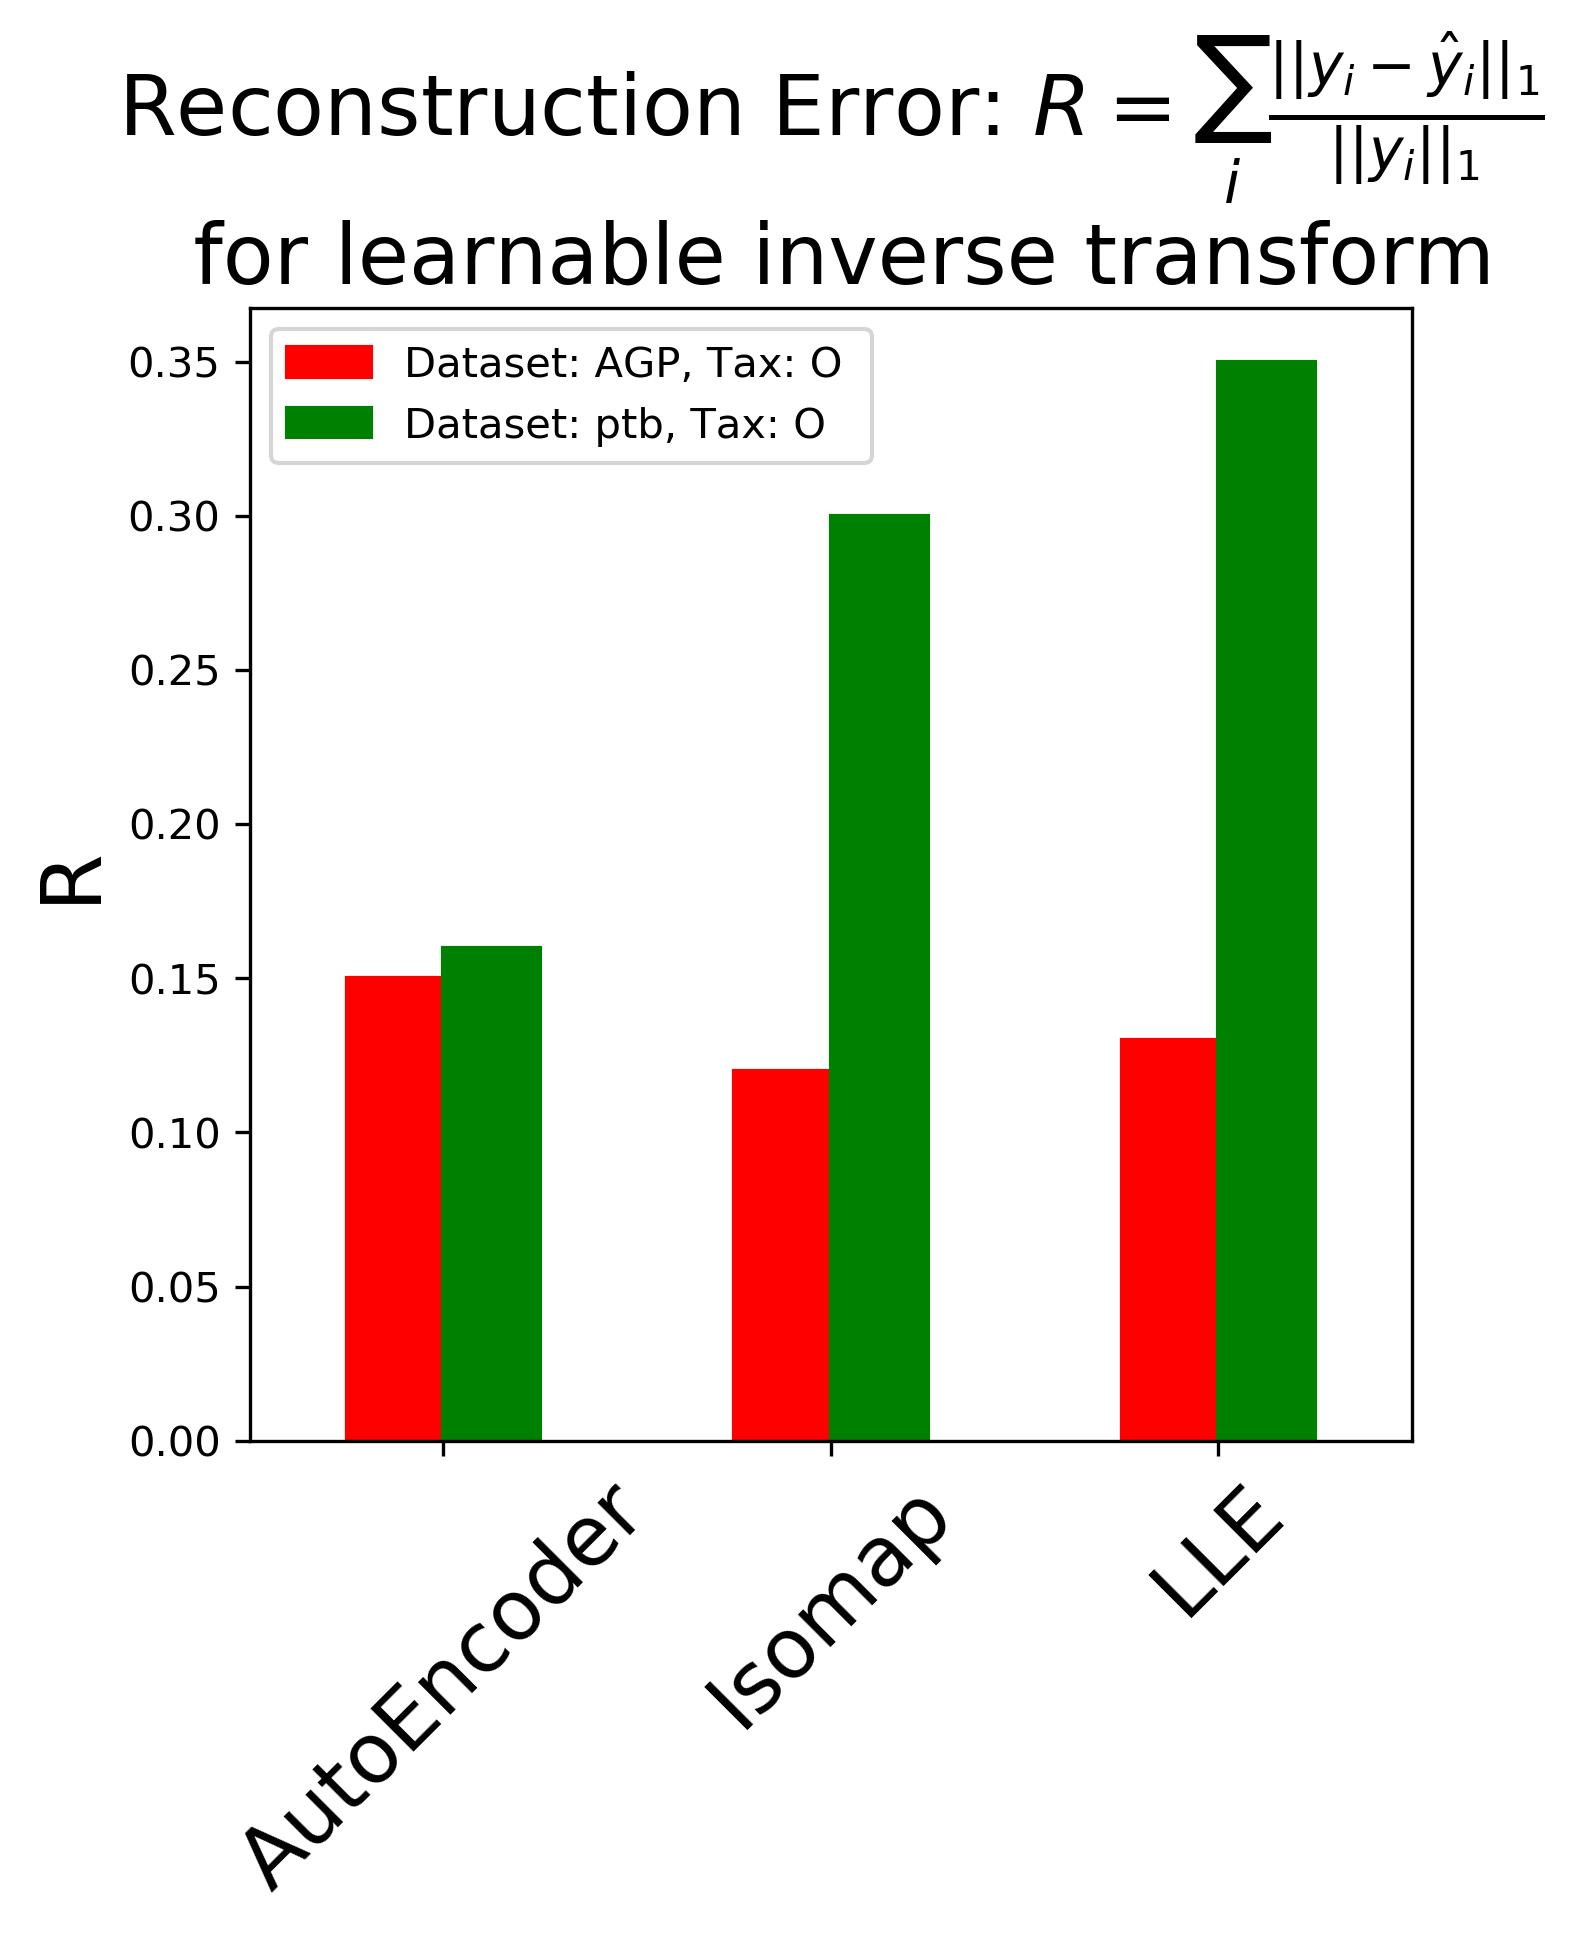

In [101]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax = fig.add_subplot(1, 1, 1) # , projection='3d'

errs_dict = pd.DataFrame({'Dataset: AGP, Tax: O ':{'AutoEncoder':0.15, 'Isomap':0.12, 'LLE':0.13},
            'Dataset: ptb, Tax: O':{'AutoEncoder':0.16, 'Isomap':0.3, 'LLE':0.35}})

barlist = errs_dict.plot.bar(ax=ax)
barlist.get_children()[0].set_color('red')
barlist.get_children()[1].set_color('red')
barlist.get_children()[2].set_color('red')
barlist.get_children()[3].set_color('green')
barlist.get_children()[4].set_color('green')
barlist.get_children()[5].set_color('green')

barlist.get_children()[-2].get_children()[0].get_children()[-1].get_children()[0].get_children()[0].get_children()[0].get_children()[0].set_color('red')
barlist.get_children()[-2].get_children()[0].get_children()[-1].get_children()[0].get_children()[1].get_children()[0].get_children()[0].set_color('green')

plt.ylabel('R', fontsize=20) # \underset{i}{\sum} 
plt.title(r'Reconstruction Error: $R = \sum_{i} \frac{||y_i - \hat{y}_i||_1}{||y_i||_1}$' + '\n for learnable inverse transform', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.show()
